# TPGMM for Gait Data with Transformed Reference Frame

In [1]:
import sys
sys.path.append("/".join(sys.path[0].split("/")[:-1]))
import json
import numpy as np
from tpgmm.tpgmm.tpgmm import TPGMM
from tpgmm.gmr.gmr import GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_trajectories, plot_ellipsoids, scatter
import matplotlib.pyplot as plt

In [2]:
with open("../data/new_processed_gait_data#39_16.json", "r") as f:
    data = json.load(f)

In [3]:
# Create separate lists for trajectories from each frame of reference
trajectories_fr1 = []
trajectories_fr2 = []

for demo in data:
    # For FR1, stack spatial features first, then time
    traj1 = np.hstack([
        demo['ankle_pos_FR1'], 
        demo['ankle_pos_FR1_velocity'], 
        demo['ankle_orientation_FR1'],
        demo['time']
    ])
    trajectories_fr1.append(traj1)
    
    # For FR2, stack spatial features first, then time
    traj2 = np.hstack([
        demo['ankle_pos_FR2'], 
        demo['ankle_pos_FR2_velocity'], 
        demo['ankle_orientation_FR2'],
        demo['time']
    ])
    trajectories_fr2.append(traj2)

# Convert lists to numpy arrays
trajectories_fr1 = np.array(trajectories_fr1)
trajectories_fr2 = np.array(trajectories_fr2)

In [4]:
from sklearn.preprocessing import StandardScaler

# Reshape the data for TPGMM
# The TPGMM expects data in the shape (num_frames, num_points, num_features)
# We have 2 frames of reference (FR1 and FR2)

# Stack the data for the two frames
num_trajectories, num_samples, num_features = trajectories_fr1.shape
reshaped_trajectories = np.stack([trajectories_fr1, trajectories_fr2], axis=0)

# Reshape to (num_frames, num_trajectories * num_samples, num_features)
reshaped_trajectories = reshaped_trajectories.reshape(2, num_trajectories * num_samples, num_features)


print(f"reshaped trajectories shape: {reshaped_trajectories.shape}")

# Fitting the model with 17 gaussian components
# We use the scaled data to ensure numerical stability
tpgmm = TPGMM(n_components=17, verbose= True, reg_factor=1e-5)

reshaped trajectories shape: (2, 3200, 6)


In [5]:
# Check for NaN or Inf values before fitting
if np.isnan(reshaped_trajectories).any() or np.isinf(reshaped_trajectories).any():
    print('Data contains NaN or Inf values. Cannot proceed with fitting.')
    print(f'Number of NaNs: {np.isnan(reshaped_trajectories).sum()}')
    print(f'Number of Infs: {np.isinf(reshaped_trajectories).sum()}')
else:
    print('Data check passed. Fitting the model...')
    #fit the model with the trajectories 
    tpgmm.fit(reshaped_trajectories)

Data check passed. Fitting the model...
Started KMeans clustering
finished KMeans clustering
Start expectation maximization
Log likelihood: 20360.122836524017 improvement 284176.6436324853
Log likelihood: 62609.162804665146 improvement 42249.03996814113
Log likelihood: 78296.19042965924 improvement 15687.027624994094
Log likelihood: 78809.39970302183 improvement 513.2092733625905
Log likelihood: 79241.50259900157 improvement 432.1028959797404
Log likelihood: 79606.47884743618 improvement 364.9762484346138
Log likelihood: 79819.98766330938 improvement 213.508815873196
Log likelihood: 79919.69793449351 improvement 99.71027118412894
Log likelihood: 79985.78478550956 improvement 66.08685101605079
Log likelihood: 80033.94805589256 improvement 48.163270382996416
Log likelihood: 80080.56465433139 improvement 46.616598438835354
Log likelihood: 80129.12900964468 improvement 48.56435531328316
Log likelihood: 80189.64941534548 improvement 60.520405700808624
Log likelihood: 80312.90576973138 impro

Second Part - GMR

In [6]:
# === Step 2: Properly extract reference frames data ===
# For this example, we'll use identity transformation for FR1 and a specific transformation for FR2
# Get a sample trajectory from the original data
sample_trajectory_idx = 6  # Using first trajectory as example
sample_trajectory = data[sample_trajectory_idx]

# Extract the trajectory data from both frames
traj_fr1 = np.hstack([
    sample_trajectory['ankle_pos_FR1'], 
    sample_trajectory['ankle_pos_FR1_velocity'], 
    sample_trajectory['ankle_orientation_FR1'],
    sample_trajectory['time']
])

traj_fr2 = np.hstack([
    sample_trajectory['ankle_pos_FR2'], 
    sample_trajectory['ankle_pos_FR2_velocity'], 
    sample_trajectory['ankle_orientation_FR2'],
    sample_trajectory['time']
])

print(f"Trajectory shape: {traj_fr1.shape}")  # Should be (200, 6)

Trajectory shape: (200, 6)


Step 2: Properly extract reference frames data

In [7]:

# === Step 2: Properly extract reference frames data ===
# For this example, we'll use identity transformation for FR1 and a specific transformation for FR2
# Number of time steps
num_timesteps = traj_fr1.shape[0]



Step 3: Create GMR instance

In [8]:
# === Step 3: Create GMR instance ===
# Using X and Y positions (indices 0, 1) as input
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# === Step 4: Verify dimensions match ===
print(f"TPGMM means shape: {tpgmm.means_.shape}")  # Should be (2, 17, 6)
print(f"TPGMM covariances shape: {tpgmm.covariances_.shape}")  # Should be (2, 17, 6, 6)
print(f"GMR input dimensions: {gmr.input_idx}")
print(f"GMR output dimensions: {gmr.output_idx}")

TPGMM means shape: (2, 17, 6)
TPGMM covariances shape: (2, 17, 6, 6)
GMR input dimensions: [0, 1]
GMR output dimensions: [2, 3, 4, 5]


In [10]:
# === Step 5: Try GMR fitting ===
# First, let's create GMR with identity transformation (original)
gmr_original = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# Fit with identity transformation
identity_translation = np.zeros((1, 4))# [None].repeat(200, axis=1) # 200 points, 5 output dims
identity_translation = identity_translation.repeat(2, axis=0)  # Repeat for both frames

identity_rotation = np.array([np.eye(4)])#[None].repeat(200, axis=1 ) #5x5 identity
identity_rotation = identity_rotation.repeat(2, axis=0)  # Repeat for both frames

print(f"identity_translation shape: {identity_translation.shape}")  # Should be (2, 5)
print(f"identity_rotation shape: {identity_rotation.shape}")  # Should be (2, 5, 5)

gmr_original.fit(translation=identity_translation, rotation_matrix=identity_rotation)
print("-"*50)

# Now create GMR with transformation
gmr_transformed = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[0, 1])

# Define a transformation (e.g., 45-degree rotation and translation)
angle_transform = np.pi/10#
rot_2d_transform = np.array([
    [np.cos(angle_transform), -np.sin(angle_transform)],
    [np.sin(angle_transform), np.cos(angle_transform)]
])

rot_4d_transform = np.eye(4)
# rot_4d_transform[0:2, 0:2] = rot_2d_transform  # Rotate velocity
print(f"rot_4d_transform shape: \n {rot_4d_transform}")  

transform_translation = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])  # 2 frames
transform_rotation = np.array([np.eye(4), rot_4d_transform])  # 2 frames

gmr_transformed.fit(translation=transform_translation, rotation_matrix=transform_rotation)



identity_translation shape: (2, 4)
identity_rotation shape: (2, 4, 4)
fit Rotation matrix shape: (2, 6, 6)
fit Translation shape: (2, 6)
eq5 Sorted means shape: (2, 17, 6)
eq5 Sorted covariances shape: (2, 17, 6, 6)
--------------------------------------------------
rot_4d_transform shape: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
fit Rotation matrix shape: (2, 6, 6)
fit Translation shape: (2, 6)
eq5 Sorted means shape: (2, 17, 6)
eq5 Sorted covariances shape: (2, 17, 6, 6)


Input positions shape: (200, 2)


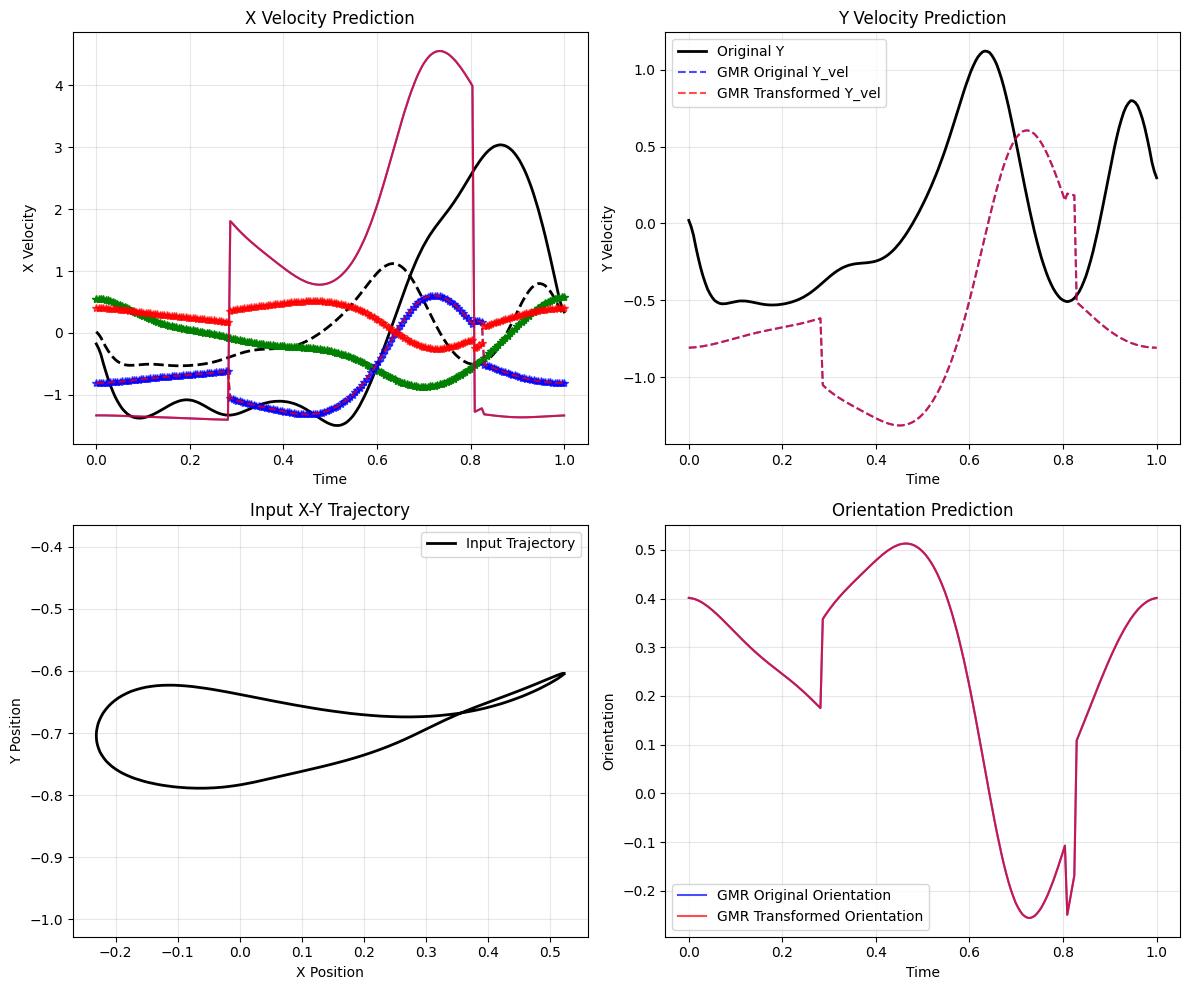

In [11]:
# === Step 6: Plot the obtained trajectory ===
# Generate input positions for prediction
# Use the original X, Y positions as input
input_positions = traj_fr1[:, :2]  # X, Y positions
print(f"Input positions shape: {input_positions.shape}")  # Should be (200, 2)

# Predict from both GMR models
pred_original_mean, pred_original_cov = gmr_original.predict(input_positions)
pred_transformed_mean, pred_transformed_cov = gmr_transformed.predict(input_positions)

# Extract predicted X, Y positions (they are part of the output)
# Since we used X,Y as input, the output contains: X_vel, Y_vel, orientation
# But we can also plot the velocities

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot original vs transformed X position over time
axes[0, 0].plot(sample_trajectory['time'], traj_fr1[:, 2], 'k-', label='Original X', linewidth=2)
axes[0, 0].plot(sample_trajectory['time'], traj_fr1[:, 3], 'k--', label='Original X', linewidth=2)
axes[0, 0].plot(sample_trajectory['time'], traj_fr1[:, 4], 'g*', label='Original X', linewidth=2)
axes[0, 0].plot(sample_trajectory['time'], pred_original_mean[:, 0], 'b-', label='GMR Original X_vel', alpha=0.7)
axes[0, 0].plot(sample_trajectory['time'], pred_original_mean[:, 1], 'b--', label='GMR Original X_vel', alpha=0.7)
axes[0, 0].plot(sample_trajectory['time'], pred_original_mean[:,1], 'b*', label='GMR Original X_vel', alpha=0.7)
axes[0, 0].plot(sample_trajectory['time'], pred_transformed_mean[:, 0], 'r-', label='GMR Transformed X_vel', alpha=0.7)
axes[0, 0].plot(sample_trajectory['time'], pred_transformed_mean[:, 1], 'r--', label='GMR Transformed X_vel', alpha=0.7)
axes[0, 0].plot(sample_trajectory['time'], pred_transformed_mean[:, 2], 'r*', label='GMR Transformed X_vel', alpha=0.7)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('X Velocity')
axes[0, 0].set_title('X Velocity Prediction')
# axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot original vs transformed Y position over time
axes[0, 1].plot(sample_trajectory['time'], traj_fr1[:, 3], 'k-', label='Original Y', linewidth=2)
axes[0, 1].plot(sample_trajectory['time'], pred_original_mean[:, 1], 'b--', label='GMR Original Y_vel', alpha=0.7)
axes[0, 1].plot(sample_trajectory['time'], pred_transformed_mean[:, 1], 'r--', label='GMR Transformed Y_vel', alpha=0.7)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Y Velocity')
axes[0, 1].set_title('Y Velocity Prediction')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot X-Y trajectory
axes[1, 0].plot(input_positions[:, 0], input_positions[:, 1], 'k-', label='Input Trajectory', linewidth=2)
axes[1, 0].set_xlabel('X Position')
axes[1, 0].set_ylabel('Y Position')
axes[1, 0].set_title('Input X-Y Trajectory')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axis('equal')

# Plot orientation prediction
axes[1, 1].plot(sample_trajectory['time'], pred_original_mean[:, 2], 'b-', label='GMR Original Orientation', alpha=0.7)
axes[1, 1].plot(sample_trajectory['time'], pred_transformed_mean[:, 2], 'r-', label='GMR Transformed Orientation', alpha=0.7)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Orientation')
axes[1, 1].set_title('Orientation Prediction')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction shapes:
Input shape: (200, 2)
Original prediction mean shape: (200, 4)
Transformed prediction mean shape: (200, 4)


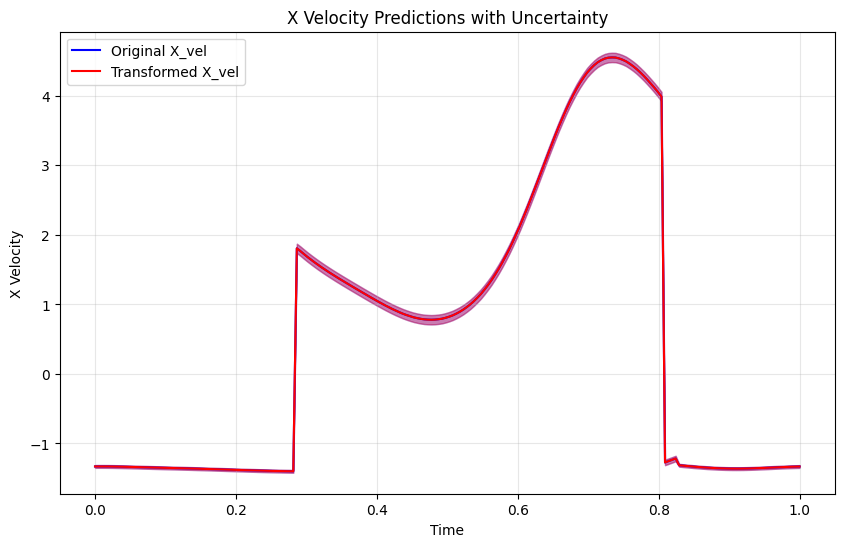

In [12]:
# Print prediction shapes for verification
print(f"\nPrediction shapes:")
print(f"Input shape: {input_positions.shape}")  # (200, 2)
print(f"Original prediction mean shape: {pred_original_mean.shape}")  # (200, 3) - X_vel, Y_vel, orientation
print(f"Transformed prediction mean shape: {pred_transformed_mean.shape}")  # (200, 3)

# Optionally, plot uncertainty (standard deviation)
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))

# Extract standard deviations
std_original = np.sqrt(np.diagonal(pred_original_cov, axis1=1, axis2=2))
std_transformed = np.sqrt(np.diagonal(pred_transformed_cov, axis1=1, axis2=2))

# Plot X velocity with uncertainty bands
time = np.array([sample_trajectory['time']]).flatten()
ax.plot(time, pred_original_mean[:, 0], 'b-', label='Original X_vel')
ax.fill_between(time, 
                pred_original_mean[:, 0] - std_original[:, 0],
                pred_original_mean[:, 0] + std_original[:, 0],
                alpha=0.3, color='blue')

ax.plot(time, pred_transformed_mean[:, 0], 'r-', label='Transformed X_vel')
ax.fill_between(time,
                pred_transformed_mean[:, 0] - std_transformed[:, 0],
                pred_transformed_mean[:, 0] + std_transformed[:, 0],
                alpha=0.3, color='red')

ax.set_xlabel('Time')
ax.set_ylabel('X Velocity')
ax.set_title('X Velocity Predictions with Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()